# FoodGeniusAI Prediction Prediction Workflow Workflow

## 📦 Importing Modules and Loading Models

In [1]:
import foodgenius.model_builder as model_builder
from timeit import default_timer as timer
import torch
from typing import Tuple, Dict

with open('class_names.txt', 'r') as file:
    class_names = file.read().splitlines()


food_nonfood_class_names = ['food', 'non_food']


effnetb2, effnetb2_transforms = model_builder.create_effnetb2_model(num_classes=len(class_names))
effnetb2.load_state_dict(torch.load(f='models/pretrained_effnetb2_food_101.pth', map_location='cpu'))

food_nonfood_model, food_nonfood_transforms = model_builder.create_effnetb2_model(num_classes=len(food_nonfood_class_names))
food_nonfood_model.load_state_dict(torch.load(f='models/pretrained_effnetb2_food_or_nonfood.pth', map_location='cpu'))

/root/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

## 🔍 Prediction Function

In [2]:
def predict(img) -> Tuple[Dict, float]:
    
    start_time = timer()
    
    
    img_transformed = food_nonfood_transforms(img).unsqueeze(0).to('cpu')
    
    # Perform food vs. nonfood classification
    food_nonfood_model.eval()
    with torch.inference_mode():
        food_nonfood_pred_probs = torch.softmax(food_nonfood_model(img_transformed), dim=1)
    
    # Check if the image is classified as food
    is_food = food_nonfood_pred_probs[0][0] > 0.5  # Assuming threshold of 0.5 for food
    
    if is_food:
        img_transformed = effnetb2_transforms(img).unsqueeze(0).to('cpu')
        
        effnetb2.eval()
        with torch.inference_mode():
            pred_probs = torch.softmax(effnetb2(img_transformed), dim=1)
        
        pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    else:
        pred_labels_and_probs = {'nonfood': float(food_nonfood_pred_probs[0][1])}
    
    pred_time = round(timer() - start_time, 5)
    
    return pred_labels_and_probs, pred_time

## 📊 Plotting Predictions 

In [6]:
import matplotlib.pyplot as plt
def plot_top_10_predictions(predictions: Dict):
    """Plots the top 10 predictions."""
    # Sort predictions by probability
    sorted_preds = sorted(predictions.items(), key=lambda item: item[1], reverse=True)[:10]
    
    labels, probs = zip(*sorted_preds)
    
    plt.figure(figsize=(10, 5))
    plt.barh(labels, probs, color='skyblue')
    plt.xlabel('Probability')
    plt.title('Top 10 Predictions')
    plt.gca().invert_yaxis()
    plt.show()

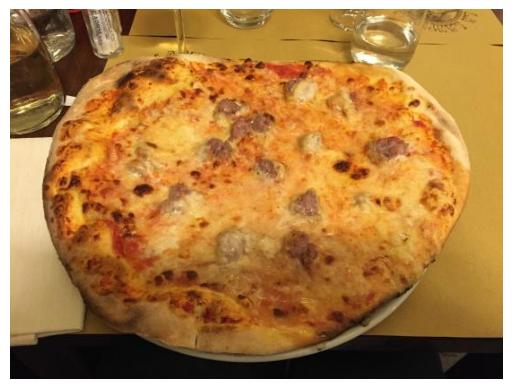

Time taken: 0.09751 seconds


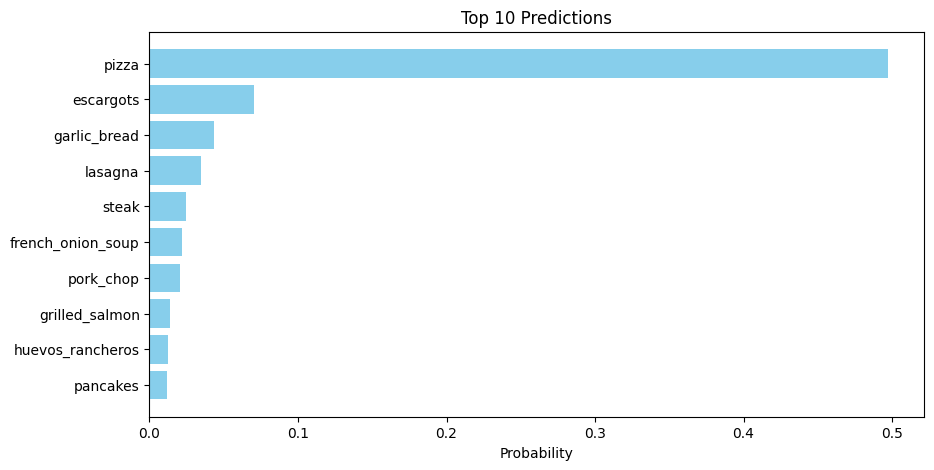

In [16]:
from PIL import Image

import matplotlib.pyplot as plt

# Load the image
img_path = 'examples/images/pizza.jpg'
img = Image.open(img_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Predict the image
pred_labels_and_probs, pred_time = predict(img)
print(f"Time taken: {pred_time} seconds")
plot_top_10_predictions(pred_labels_and_probs)